# Objetivo

La compañia de telecomunicaciones Megaline ofrece a sus clientes dos tarifas de prepago, Surf y Ultimate. El departamento comercial quiere saber cuál de las tarifas genera más ingresos para poder ajustar el presupuesto de publicidad.

Se realiza un análisis preliminar de las tarifas basado en una selección de clientes relativamente pequeña. Se tienen los datos de 500 clientes de Megaline: quiénes son los clientes, de dónde son, qué tarifa usan, así como la cantidad de llamadas que hicieron y los mensajes de texto que enviaron en 2018. 

Se analiza el comportamiento de los clientes y se determina qué tarifa de prepago genera más ingresos.

## Inicialización

In [1]:
# importación de librerias
import pandas as pd
import numpy as np
import math
from matplotlib import pyplot as plt
from scipy import stats as st

## Cargar datos

In [2]:
users = pd.read_csv("/datasets/megaline_users.csv")
calls = pd.read_csv("/datasets/megaline_calls.csv")
messages = pd.read_csv("/datasets/megaline_messages.csv")
internet = pd.read_csv("/datasets/megaline_internet.csv")
plans = pd.read_csv("/datasets/megaline_plans.csv")

## Exploración de los datos

## Tarifas

In [3]:
plans.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   messages_included      2 non-null      int64  
 1   mb_per_month_included  2 non-null      int64  
 2   minutes_included       2 non-null      int64  
 3   usd_monthly_pay        2 non-null      int64  
 4   usd_per_gb             2 non-null      int64  
 5   usd_per_message        2 non-null      float64
 6   usd_per_minute         2 non-null      float64
 7   plan_name              2 non-null      object 
dtypes: float64(2), int64(5), object(1)
memory usage: 256.0+ bytes


In [4]:
display(plans)

,messages_included,mb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,plan_name
0,50,15360,500,20,10,0.03,0.03,surf
1,1000,30720,3000,70,7,0.01,0.01,ultimate



    Para el caso del dataset de "plans" podemos ver que tenemos dtypes muy variado y sin datos nulos. En la muestra podemos ver la descripción exacta de los dos planes con los que trabaja Megaline, le descripción y tipo de datos concuerdan perfectamente con la descripción de cada dato, para cuestiones futuras, se convertirá la columna de "mb_per_month_included" a gb.

## Corregir datos

In [5]:
plans['gb_per_month_included'] = plans['mb_per_month_included'] / 1024
plans['gb_per_month_included'] = plans['gb_per_month_included'].astype(int)

display(plans)

,messages_included,mb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,plan_name,gb_per_month_included
0,50,15360,500,20,10,0.03,0.03,surf,15
1,1000,30720,3000,70,7,0.01,0.01,ultimate,30


## Usuarios/as

In [6]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   first_name  500 non-null    object
 2   last_name   500 non-null    object
 3   age         500 non-null    int64 
 4   city        500 non-null    object
 5   reg_date    500 non-null    object
 6   plan        500 non-null    object
 7   churn_date  34 non-null     object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


In [7]:
display(users)

print(users.describe())
print()
print('El número de registros duplicados es de:' , users.duplicated().sum() ,'filas')

,user_id,first_name,last_name,age,city,reg_date,plan,churn_date
0,1000,Anamaria,Bauer,45,"Atlanta-Sandy Springs-Roswell, GA MSA",2018-12-24,ultimate,NaN
1,1001,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,NaN
2,1002,Carlee,Hoffman,36,"Las Vegas-Henderson-Paradise, NV MSA",2018-10-21,surf,NaN
3,1003,Reynaldo,Jenkins,52,"Tulsa, OK MSA",2018-01-28,surf,NaN
4,1004,Leonila,Thompson,40,"Seattle-Tacoma-Bellevue, WA MSA",2018-05-23,surf,NaN
...,...,...,...,...,...,...,...,...
495,1495,Fidel,Sharpe,67,"New York-Newark-Jersey City, NY-NJ-PA MSA",2018-09-04,surf,NaN
496,1496,Ariel,Shepherd,49,"New Orleans-Metairie, LA MSA",2018-02-20,surf,NaN
497,1497,Donte,Barrera,49,"Los Angeles-Long Beach-Anaheim, CA MSA",2018-12-10,ultimate,NaN
498,1498,Scot,Williamson,51,"New York-Newark-Jersey City, NY-NJ-PA MSA",2018-02-04,surf,NaN


           user_id         age
count   500.000000  500.000000
mean   1249.500000   45.486000
std     144.481833   16.972269
min    1000.000000   18.000000
25%    1124.750000   30.000000
50%    1249.500000   46.000000
75%    1374.250000   61.000000
max    1499.000000   75.000000

El número de registros duplicados es de: 0 filas


    En este dataset "users" podermos ver toda la base de datos de los clientes con los cuales vamos a trabajar. Tengo curiosidad por saber que significa "MSA" en la columna de City. Para la columna reg_date, podríamos cambiar su tipo de dato de "object" a "datetime", y para la columna "Churn_date" tenemos tipo de datos object, podemos pasarlos a "datetime" también, pero a su vez tenemos datos ausentes, por lo que podríamos dejarlos por lo pronto como NaN o colocar una fecha especial para poder identificar este tipo de clientes en futuros análisis.

### Corregir los datos

In [8]:
users['reg_date'] = pd.to_datetime(users['reg_date'])
users['churn_date'] = pd.to_datetime(users['churn_date'])

Existen nulos en "churn date", se decide no rellenarlos, debido a que no es una variable que nos sea de interés por el momento.

## Llamadas

In [9]:
calls.info()
print()
print(calls.describe())
print()
print('El número de registros duplicados es de:' , calls.duplicated().sum() ,'filas')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137735 entries, 0 to 137734
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         137735 non-null  object 
 1   user_id    137735 non-null  int64  
 2   call_date  137735 non-null  object 
 3   duration   137735 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 4.2+ MB

             user_id       duration
count  137735.000000  137735.000000
mean     1247.658046       6.745927
std       139.416268       5.839241
min      1000.000000       0.000000
25%      1128.000000       1.290000
50%      1247.000000       5.980000
75%      1365.000000      10.690000
max      1499.000000      37.600000

El número de registros duplicados es de: 0 filas


In [10]:
display(calls)

,id,user_id,call_date,duration
0,1000_93,1000,2018-12-27,8.52
1,1000_145,1000,2018-12-27,13.66
2,1000_247,1000,2018-12-27,14.48
3,1000_309,1000,2018-12-28,5.76
4,1000_380,1000,2018-12-30,4.22
...,...,...,...,...
137730,1499_199,1499,2018-11-21,8.72
137731,1499_200,1499,2018-10-20,10.89
137732,1499_201,1499,2018-09-21,8.12
137733,1499_202,1499,2018-10-10,0.37


    Podemos pasar la columan "call_date" a un tipo de dato "datetime" para una mejor usabilidad de los datos y sabiendo que megaline considera lo siguiente: "Para llamadas, cada llamada individual se redondea: incluso si la llamada duró solo un segundo, se contará como un minuto." podemos tomar la columan "duration" que marca la duración de las llamadas en mínutos, y redondear hacia arriba, para después cambiarlo de un dato tipo float a un tipo integer para no tener el cero decímal volando. Aunado a lo anterior, no tenemos datos nulos de los cuales ocuparnos.

### Corregir los datos

In [11]:
calls['call_date'] = pd.to_datetime(calls['call_date'])
calls['duration'] = np.ceil(calls['duration']).astype(int)
calls['month'] = calls['call_date'].dt.month

display(calls)

,id,user_id,call_date,duration,month
0,1000_93,1000,2018-12-27,9,12
1,1000_145,1000,2018-12-27,14,12
2,1000_247,1000,2018-12-27,15,12
3,1000_309,1000,2018-12-28,6,12
4,1000_380,1000,2018-12-30,5,12
...,...,...,...,...,...
137730,1499_199,1499,2018-11-21,9,11
137731,1499_200,1499,2018-10-20,11,10
137732,1499_201,1499,2018-09-21,9,9
137733,1499_202,1499,2018-10-10,1,10


## Mensajes

In [12]:
messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76051 entries, 0 to 76050
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            76051 non-null  object
 1   user_id       76051 non-null  int64 
 2   message_date  76051 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.7+ MB


In [13]:
display(messages)
print()
print('El número de registros duplicados es de:' , messages.duplicated().sum() ,'filas')

,id,user_id,message_date
0,1000_125,1000,2018-12-27
1,1000_160,1000,2018-12-31
2,1000_223,1000,2018-12-31
3,1000_251,1000,2018-12-27
4,1000_255,1000,2018-12-26
...,...,...,...
76046,1497_526,1497,2018-12-24
76047,1497_536,1497,2018-12-24
76048,1497_547,1497,2018-12-31
76049,1497_558,1497,2018-12-24



El número de registros duplicados es de: 0 filas


    Vemos que es un dataset de solo 3 columnas, sin nulos y únicamente cambiaremos el tipo de dato de "message_date" a un tipo de dato "datetime"

### Corregir los datos

In [14]:
messages['message_date'] = pd.to_datetime(messages['message_date'])
messages['month'] = messages['message_date'].dt.month
display(messages)

,id,user_id,message_date,month
0,1000_125,1000,2018-12-27,12
1,1000_160,1000,2018-12-31,12
2,1000_223,1000,2018-12-31,12
3,1000_251,1000,2018-12-27,12
4,1000_255,1000,2018-12-26,12
...,...,...,...,...
76046,1497_526,1497,2018-12-24,12
76047,1497_536,1497,2018-12-24,12
76048,1497_547,1497,2018-12-31,12
76049,1497_558,1497,2018-12-24,12


## Internet

In [15]:
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104825 entries, 0 to 104824
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            104825 non-null  object 
 1   user_id       104825 non-null  int64  
 2   session_date  104825 non-null  object 
 3   mb_used       104825 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 3.2+ MB


In [16]:
display(internet)
print()
print(internet['mb_used'].describe())
print()
print('El número de registros duplicados es de:' , internet.duplicated().sum() ,'filas')

,id,user_id,session_date,mb_used
0,1000_13,1000,2018-12-29,89.86
1,1000_204,1000,2018-12-31,0.00
2,1000_379,1000,2018-12-28,660.40
3,1000_413,1000,2018-12-26,270.99
4,1000_442,1000,2018-12-27,880.22
...,...,...,...,...
104820,1499_215,1499,2018-10-20,218.06
104821,1499_216,1499,2018-12-30,304.72
104822,1499_217,1499,2018-09-22,292.75
104823,1499_218,1499,2018-12-07,0.00



count    104825.000000
mean        366.713701
std         277.170542
min           0.000000
25%         136.080000
50%         343.980000
75%         554.610000
max        1693.470000
Name: mb_used, dtype: float64

El número de registros duplicados es de: 0 filas


    En este dataset solo se cambiará el tipo de dato de la columna "session_date" a tipo de dato "datetime" y la columna de "mg_usde" la voy a convertir a gb, debido a que megaline calcula sus tarifas con base a gb.

### Corregir los datos

In [17]:
internet['session_date'] = pd.to_datetime(internet['session_date'])

### Enriquecer los datos

In [18]:
internet['gb_used'] = internet['mb_used'] / 1024
internet['month'] = internet['session_date'].dt.month
display(messages)

,id,user_id,message_date,month
0,1000_125,1000,2018-12-27,12
1,1000_160,1000,2018-12-31,12
2,1000_223,1000,2018-12-31,12
3,1000_251,1000,2018-12-27,12
4,1000_255,1000,2018-12-26,12
...,...,...,...,...
76046,1497_526,1497,2018-12-24,12
76047,1497_536,1497,2018-12-24,12
76048,1497_547,1497,2018-12-31,12
76049,1497_558,1497,2018-12-24,12


## Estudiar las condiciones de las tarifas

Es sumamente importante entender cómo funcionan las tarifas, cómo se les cobra a los usuarios en función de su plan de suscripción. Así que te sugerimos imprimir la información de la tarifa para ver una vez más sus condiciones.

In [19]:
display(plans)

,messages_included,mb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,plan_name,gb_per_month_included
0,50,15360,500,20,10,0.03,0.03,surf,15
1,1000,30720,3000,70,7,0.01,0.01,ultimate,30


## Agregar datos por usuario

Ahora que los datos están limpios, agrega los datos por usuario y por periodo para que solo haya un registro por usuario y por periodo. Esto facilitará mucho el análisis posterior.

In [20]:
calls_grouped = calls.groupby(['user_id', 'month']).size().reset_index(name='call_count')
display(calls)
display(calls_grouped)
calls_grouped.info()

,id,user_id,call_date,duration,month
0,1000_93,1000,2018-12-27,9,12
1,1000_145,1000,2018-12-27,14,12
2,1000_247,1000,2018-12-27,15,12
3,1000_309,1000,2018-12-28,6,12
4,1000_380,1000,2018-12-30,5,12
...,...,...,...,...,...
137730,1499_199,1499,2018-11-21,9,11
137731,1499_200,1499,2018-10-20,11,10
137732,1499_201,1499,2018-09-21,9,9
137733,1499_202,1499,2018-10-10,1,10


,user_id,month,call_count
0,1000,12,16
1,1001,8,27
2,1001,9,49
3,1001,10,65
4,1001,11,64
...,...,...,...
2253,1498,12,39
2254,1499,9,41
2255,1499,10,53
2256,1499,11,45


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2258 entries, 0 to 2257
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   user_id     2258 non-null   int64
 1   month       2258 non-null   int64
 2   call_count  2258 non-null   int64
dtypes: int64(3)
memory usage: 53.0 KB


In [21]:
calls_sum = calls.groupby(['user_id', 'month'])['duration'].sum().reset_index()
calls_sum = calls_sum.rename(columns={'duration': "minutes_used"})

display(calls_sum)

,user_id,month,minutes_used
0,1000,12,124
1,1001,8,182
2,1001,9,315
3,1001,10,393
4,1001,11,426
...,...,...,...
2253,1498,12,339
2254,1499,9,346
2255,1499,10,385
2256,1499,11,308


In [22]:
messages_grouped = messages.groupby(['user_id','month']).size().reset_index(name='message_count')

display(messages)
display(messages_grouped)
messages_grouped.info()

,id,user_id,message_date,month
0,1000_125,1000,2018-12-27,12
1,1000_160,1000,2018-12-31,12
2,1000_223,1000,2018-12-31,12
3,1000_251,1000,2018-12-27,12
4,1000_255,1000,2018-12-26,12
...,...,...,...,...
76046,1497_526,1497,2018-12-24,12
76047,1497_536,1497,2018-12-24,12
76048,1497_547,1497,2018-12-31,12
76049,1497_558,1497,2018-12-24,12


,user_id,month,message_count
0,1000,12,11
1,1001,8,30
2,1001,9,44
3,1001,10,53
4,1001,11,36
...,...,...,...
1801,1496,9,21
1802,1496,10,18
1803,1496,11,13
1804,1496,12,11


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1806 entries, 0 to 1805
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype
---  ------         --------------  -----
 0   user_id        1806 non-null   int64
 1   month          1806 non-null   int64
 2   message_count  1806 non-null   int64
dtypes: int64(3)
memory usage: 42.5 KB


In [23]:
internet_grouped = internet.groupby(['user_id','month'])['gb_used'].sum().reset_index()
internet_grouped['gb_rounded'] = np.ceil(internet_grouped['gb_used']).astype(int)
internet_grouped = internet_grouped.drop('gb_used', axis='columns')

display(internet_grouped)

,user_id,month,gb_rounded
0,1000,12,2
1,1001,8,7
2,1001,9,14
3,1001,10,22
4,1001,11,19
...,...,...,...
2272,1498,12,23
2273,1499,9,13
2274,1499,10,20
2275,1499,11,17


In [24]:
# Fusiona los datos de llamadas, minutos, mensajes e Internet con base en user_id y month
merged_df = internet_grouped.merge(calls_grouped, on=['user_id', 'month'], how='outer')
merged_df = merged_df.merge(calls_sum, on=['user_id', 'month'], how='outer')
merged_df = merged_df.merge(messages_grouped, on=['user_id', 'month'], how='outer')
merged_df.fillna(0, inplace=True)

merged_df['gb_rounded'] = merged_df['gb_rounded'].astype(int)
merged_df['call_count'] = merged_df['call_count'].astype(int)
merged_df['minutes_used'] = merged_df['minutes_used'].astype(int)
merged_df['message_count'] = merged_df['message_count'].astype(int)

display(merged_df)
merged_df.info()
print()


,user_id,month,gb_rounded,call_count,minutes_used,message_count
0,1000,12,2,16,124,11
1,1001,8,7,27,182,30
2,1001,9,14,49,315,44
3,1001,10,22,65,393,53
4,1001,11,19,64,426,36
...,...,...,...,...,...,...
2288,1470,11,0,81,632,156
2289,1470,12,0,78,592,153
2290,1484,11,0,2,38,1
2291,1491,4,0,8,44,6


<class 'pandas.core.frame.DataFrame'>
Int64Index: 2293 entries, 0 to 2292
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype
---  ------         --------------  -----
 0   user_id        2293 non-null   int64
 1   month          2293 non-null   int64
 2   gb_rounded     2293 non-null   int64
 3   call_count     2293 non-null   int64
 4   minutes_used   2293 non-null   int64
 5   message_count  2293 non-null   int64
dtypes: int64(6)
memory usage: 125.4 KB



In [25]:
users_plan = users[['user_id', 'plan','city']]
merged_df = merged_df.merge(users_plan, on=['user_id'], how='left')

display(merged_df)

,user_id,month,gb_rounded,call_count,minutes_used,message_count,plan,city
0,1000,12,2,16,124,11,ultimate,"Atlanta-Sandy Springs-Roswell, GA MSA"
1,1001,8,7,27,182,30,surf,"Seattle-Tacoma-Bellevue, WA MSA"
2,1001,9,14,49,315,44,surf,"Seattle-Tacoma-Bellevue, WA MSA"
3,1001,10,22,65,393,53,surf,"Seattle-Tacoma-Bellevue, WA MSA"
4,1001,11,19,64,426,36,surf,"Seattle-Tacoma-Bellevue, WA MSA"
...,...,...,...,...,...,...,...,...
2288,1470,11,0,81,632,156,surf,"Washington-Arlington-Alexandria, DC-VA-MD-WV MSA"
2289,1470,12,0,78,592,153,surf,"Washington-Arlington-Alexandria, DC-VA-MD-WV MSA"
2290,1484,11,0,2,38,1,surf,"Dallas-Fort Worth-Arlington, TX MSA"
2291,1491,4,0,8,44,6,surf,"Grand Rapids-Kentwood, MI MSA"


.

In [26]:

merged_data_rate = merged_df.merge(plans, left_on='plan', right_on='plan_name', how='left')

merged_data_rate['call_cost'] = (merged_data_rate['minutes_used'] - merged_data_rate['minutes_included']) * merged_data_rate['usd_per_minute']
merged_data_rate['message_cost'] = (merged_data_rate['message_count'] - merged_data_rate['messages_included']) * merged_data_rate['usd_per_message']
merged_data_rate['data_cost'] = (merged_data_rate['gb_rounded'] - merged_data_rate['gb_per_month_included']) * merged_data_rate['usd_per_gb']

merged_data_rate.loc[merged_data_rate['call_cost'] < 0, 'call_cost'] = 0
merged_data_rate.loc[merged_data_rate['message_cost'] < 0, 'message_cost'] = 0
merged_data_rate.loc[merged_data_rate['data_cost'] < 0, 'data_cost'] = 0

merged_data_rate['total_revenue'] = merged_data_rate['usd_monthly_pay'] + merged_data_rate['call_cost'] + merged_data_rate['message_cost'] + merged_data_rate['data_cost']

display(merged_data_rate)

,user_id,month,gb_rounded,call_count,minutes_used,message_count,plan,city,messages_included,mb_per_month_included,...,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,plan_name,gb_per_month_included,call_cost,message_cost,data_cost,total_revenue
0,1000,12,2,16,124,11,ultimate,"Atlanta-Sandy Springs-Roswell, GA MSA",1000,30720,...,70,7,0.01,0.01,ultimate,30,0.00,0.00,0,70.00
1,1001,8,7,27,182,30,surf,"Seattle-Tacoma-Bellevue, WA MSA",50,15360,...,20,10,0.03,0.03,surf,15,0.00,0.00,0,20.00
2,1001,9,14,49,315,44,surf,"Seattle-Tacoma-Bellevue, WA MSA",50,15360,...,20,10,0.03,0.03,surf,15,0.00,0.00,0,20.00
3,1001,10,22,65,393,53,surf,"Seattle-Tacoma-Bellevue, WA MSA",50,15360,...,20,10,0.03,0.03,surf,15,0.00,0.09,70,90.09
4,1001,11,19,64,426,36,surf,"Seattle-Tacoma-Bellevue, WA MSA",50,15360,...,20,10,0.03,0.03,surf,15,0.00,0.00,40,60.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2288,1470,11,0,81,632,156,surf,"Washington-Arlington-Alexandria, DC-VA-MD-WV MSA",50,15360,...,20,10,0.03,0.03,surf,15,3.96,3.18,0,27.14
2289,1470,12,0,78,592,153,surf,"Washington-Arlington-Alexandria, DC-VA-MD-WV MSA",50,15360,...,20,10,0.03,0.03,surf,15,2.76,3.09,0,25.85
2290,1484,11,0,2,38,1,surf,"Dallas-Fort Worth-Arlington, TX MSA",50,15360,...,20,10,0.03,0.03,surf,15,0.00,0.00,0,20.00
2291,1491,4,0,8,44,6,surf,"Grand Rapids-Kentwood, MI MSA",50,15360,...,20,10,0.03,0.03,surf,15,0.00,0.00,0,20.00


Con base a las bases de datos proporcionadas, se realizó una limpieza y adaptación de datos, con el fin de poder tener una base de datos confiable que nos arroje datos confiables.
    
Hemos trabajado para poder obterner una matriz única con todos los datos que se nos proporcionaro. Esta matriz única converge los datos más importantes para nuestro análisis, por citar algunos ejemplos, el id del cliente, unicación regional del cliente, plan contratado, mensajes, llamadas y gb utilizados por cada mes, total de facturación por mes, etc. 

## Estudia el comportamiento de usuario

### Llamadas

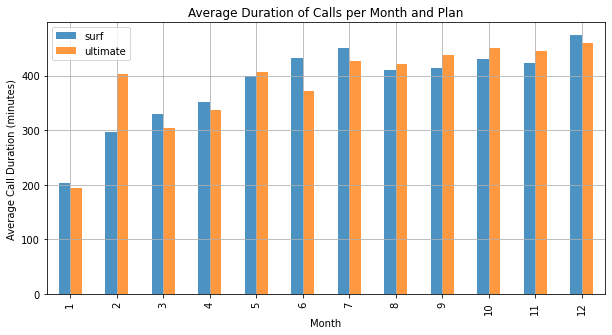

In [27]:
avg_call_duration = merged_data_rate.groupby(['plan', 'month'])['minutes_used'].mean().reset_index()
avg_call_duration['minutes_used'] = avg_call_duration['minutes_used'].round(1)

pivot_table = avg_call_duration.pivot(index='month', columns='plan', values='minutes_used')
pivot_table.columns = ['surf', 'ultimate']
pivot_table.reset_index(inplace=True)

pivot_table.plot(kind='bar',
                 x= 'month',
                 figsize=(10, 5),
                 title='Average Duration of Calls per Month and Plan',
                 xlabel='Month',
                 ylabel='Average Call Duration (minutes)',  
                 alpha=0.8, 
                 grid=True)

plt.show()

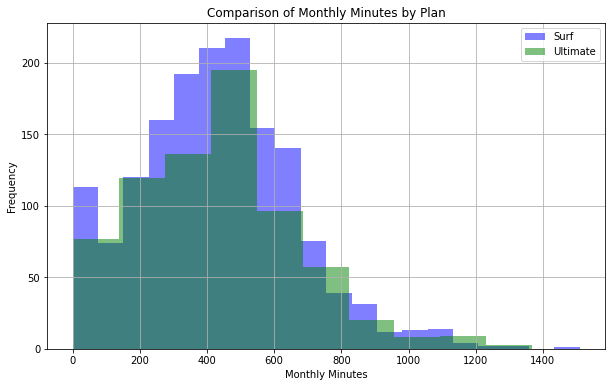

Media de la duración mensual de llamadas (Surf): 428.7
Media de la duración mensual de llamadas (Ultimate): 430.4
Varianza de la duración mensual de llamadas (Surf): 54968.3
Varianza de la duración mensual de llamadas (Ultimate): 57844.5


In [28]:
surf_data = merged_data_rate[merged_data_rate['plan'] == 'surf']['minutes_used']
ultimate_data = merged_data_rate[merged_data_rate['plan'] == 'ultimate']['minutes_used']

plt.figure(figsize=(10, 6))
plt.hist(surf_data, bins=20, alpha=0.5, label='Surf', color='blue')
plt.hist(ultimate_data, bins=10, alpha=0.5, label='Ultimate', color='green')

plt.xlabel('Monthly Minutes')
plt.ylabel('Frequency')
plt.title('Comparison of Monthly Minutes by Plan')
plt.legend()
plt.grid(True)

plt.show()


surf_mean = merged_data_rate[merged_data_rate['plan'] == 'surf']['minutes_used'].mean().round(1)
ultimate_mean = merged_data_rate[merged_data_rate['plan'] == 'ultimate']['minutes_used'].mean().round(1)

surf_variance = merged_data_rate[merged_data_rate['plan'] == 'surf']['minutes_used'].var().round(1)
ultimate_variance = merged_data_rate[merged_data_rate['plan'] == 'ultimate']['minutes_used'].var().round(1)

print("Media de la duración mensual de llamadas (Surf):", surf_mean)
print("Media de la duración mensual de llamadas (Ultimate):", ultimate_mean)

print("Varianza de la duración mensual de llamadas (Surf):", surf_variance)
print("Varianza de la duración mensual de llamadas (Ultimate):", ultimate_variance)

    En promedio, los usuarios de ambos planes tienen duraciones de llamadas mensuales similares, con el plan "Ultimate" teniendo una duración ligeramente más alta en promedio. 
    Recordando que los clientes del plan "Surf" solo tienen incluido en su plan 500 minutos y los clientes del plan "Ultimate" es de 3000 minutos. La cantidad de minutos que sobrepasen este limite tendrán un costo extra.
    Ambos planes muestran una alta variabilidad en la duración de las llamadas, por loq ue tenemos una gama amplia en el comportamiento de uso de minutos de los usuarios.
    La diferencia en las varianzas entre los dos planes no es significativamente grande, lo que indica que la variabilidad en la duración de las llamadas es comparable entre los dos grupos.
    

In [29]:
print(merged_data_rate['minutes_used'].describe())
print()

mean_duration = merged_data_rate['minutes_used'].mean().round(1)
variance_duration = merged_data_rate['minutes_used'].var().round(1)
median_duration = merged_data_rate['minutes_used'].median()
mode_duration = merged_data_rate['minutes_used'].mode()[0]
std_duration = merged_data_rate['minutes_used'].std()

print("Media de la duración mensual de llamadas:", mean_duration)
print("Varianza de la duración mensual de llamadas:", variance_duration)
print("Mediana de la duración mensual de llamadas:", median_duration)
print("La desviación estandar de la duración mensual de llamadas:", std_duration)
print("Moda de la duración mensual de llamadas:", mode_duration)


count    2293.000000
mean      429.283471
std       236.320077
min         0.000000
25%       265.000000
50%       425.000000
75%       572.000000
max      1510.000000
Name: minutes_used, dtype: float64

Media de la duración mensual de llamadas: 429.3
Varianza de la duración mensual de llamadas: 55847.2
Mediana de la duración mensual de llamadas: 425.0
La desviación estandar de la duración mensual de llamadas: 236.3200769532499
Moda de la duración mensual de llamadas: 0


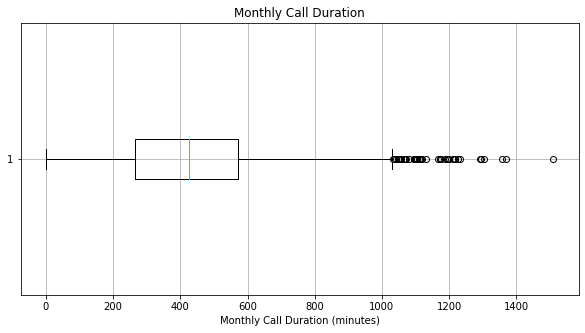

El valor del Q1 es de: 265.0
El valor del Q3 es de: 572.0
El valor máximo es de: 1032.5
El valor máximo átipico es: 1510


In [30]:
duration_data = merged_data_rate['minutes_used']

plt.figure(figsize=(10, 5))
plt.boxplot(duration_data, vert=False)
plt.xlabel('Monthly Call Duration (minutes)')
plt.title('Monthly Call Duration')
plt.grid(True)

plt.show()

q1 = np.percentile(duration_data, 25)
q3 = np.percentile(duration_data, 75)

print('El valor del Q1 es de:' ,q1)
print('El valor del Q3 es de:' ,q3)

max_value = q3 + (1.5*(q3-q1))
print('El valor máximo es de:' , max_value)

maximum_atypical_value = np.max(duration_data)
print('El valor máximo átipico es:' ,maximum_atypical_value)



    El comportamiento de los usuarios para ambos planes se comportan de una manera muy similar, sin importar mucho el plan contratado. En los datos atípicos positivos que tenemos podemos ver con el boxplot y el histograma, podemos observar que a pesar de ser atipicos, no se ven influenciados por el tipo de plan que el cliente tenga contratado.

### Mensajes

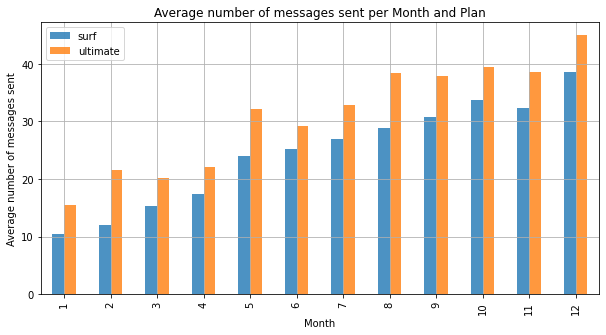

In [31]:
avg_message_sent = merged_data_rate.groupby(['plan', 'month'])['message_count'].mean().reset_index()
avg_message_sent['message_count'] = avg_message_sent['message_count'].round(1)

pivot_table_msg = avg_message_sent.pivot(index='month', columns='plan', values='message_count')
pivot_table_msg.columns = ['surf', 'ultimate']
pivot_table_msg.reset_index(inplace=True)

pivot_table_msg.plot(kind='bar',
                     x= 'month',
                     figsize=(10, 5),
                     title='Average number of messages sent per Month and Plan',
                     xlabel='Month',
                     ylabel='Average number of messages sent',  
                     alpha=0.8, 
                     grid=True)

plt.show()

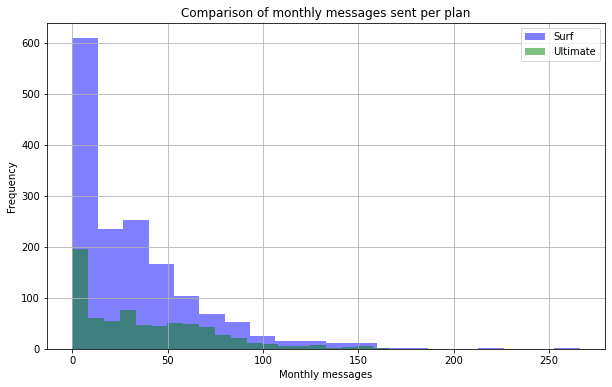

Media de SMS enviados (Surf): 31.2
Media de SMS enviados (Ultimate): 37.6
Varianza de los SMS enviados (Surf): 1126.7
Varianza de los SMS enviados (Ultimate): 1208.8
Mediana de SMS enviados (Surf): 24.0
Mediana de los SMS enviados (Ultimate): 30.0
Moda de SMS enviados (Surf): 0
Moda de los SMS enviados (Ultimate) 0
La desviación estandar de SMS enviados (Surf): 33.6
La desviación estandar de los SMS enviados (Ultimate) 34.8


In [32]:
surf_message = merged_data_rate[merged_data_rate['plan'] == 'surf']['message_count']
ultimate_message = merged_data_rate[merged_data_rate['plan'] == 'ultimate']['message_count']

plt.figure(figsize=(10, 6))
plt.hist(surf_message, bins=20, alpha=0.5, label='Surf', color='blue')
plt.hist(ultimate_message, bins=20, alpha=0.5, label='Ultimate', color='green')

plt.xlabel('Monthly messages')
plt.ylabel('Frequency')
plt.title('Comparison of monthly messages sent per plan')
plt.legend()
plt.grid(True)

plt.show()

surf_message_m = merged_data_rate[merged_data_rate['plan'] == 'surf']['message_count'].mean()
ultimate_message_m = merged_data_rate[merged_data_rate['plan'] == 'ultimate']['message_count'].mean()
surf_message_variance = merged_data_rate[merged_data_rate['plan'] == 'surf']['message_count'].var()
ultimate_message_variance = merged_data_rate[merged_data_rate['plan'] == 'ultimate']['message_count'].var()
surf_message_median = merged_data_rate[merged_data_rate['plan'] == 'surf']['message_count'].median()
ultimate_message_median = merged_data_rate[merged_data_rate['plan'] == 'ultimate']['message_count'].median()
surf_message_mode = merged_data_rate[merged_data_rate['plan'] == 'surf']['message_count'].mode()[0]
ultimate_message_mode = merged_data_rate[merged_data_rate['plan'] == 'ultimate']['message_count'].mode()[0]
surf_message_std = merged_data_rate[merged_data_rate['plan'] == 'surf']['message_count'].std()
ultimate_message_std = merged_data_rate[merged_data_rate['plan'] == 'ultimate']['message_count'].std()

print("Media de SMS enviados (Surf):", surf_message_m.round(1))
print("Media de SMS enviados (Ultimate):", ultimate_message_m.round(1))
print("Varianza de los SMS enviados (Surf):", surf_message_variance.round(1))
print("Varianza de los SMS enviados (Ultimate):", ultimate_message_variance.round(1))
print("Mediana de SMS enviados (Surf):", surf_message_median.round(1))
print("Mediana de los SMS enviados (Ultimate):", ultimate_message_median.round(1))
print("Moda de SMS enviados (Surf):", surf_message_mode.round(1))
print("Moda de los SMS enviados (Ultimate)", ultimate_message_mode.round(1))
print("La desviación estandar de SMS enviados (Surf):", surf_message_std.round(1))
print("La desviación estandar de los SMS enviados (Ultimate)", ultimate_message_std.round(1))

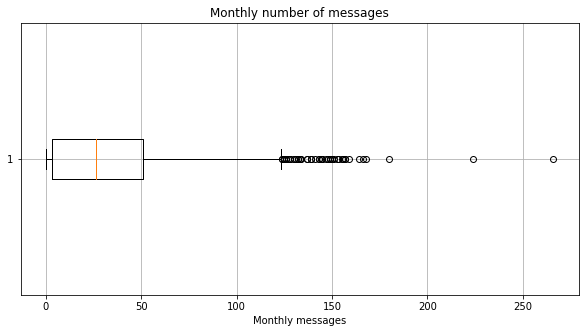

El valor del Q1 es de: 3.0
El valor del Q3 es de: 51.0
El valor máximo es de: 123.0
El valor máximo átipico es: 266


In [33]:
message_data = merged_data_rate['message_count']

plt.figure(figsize = (10,5))
plt.boxplot(message_data, vert=False)
plt.xlabel('Monthly messages')
plt.title('Monthly number of messages')
plt.grid(True)

plt.show()

q1_m = np.percentile(message_data, 25)
q3_m = np.percentile(message_data, 75)

print('El valor del Q1 es de:' ,q1_m)
print('El valor del Q3 es de:' ,q3_m)

max_value_m = q3_m + (1.5*(q3_m-q1_m))
print('El valor máximo es de:' , max_value_m)

maximum_atypical_value_m = np.max(message_data)
print('El valor máximo átipico es:' ,maximum_atypical_value_m)

[Elabora las conclusiones sobre el comportamiento de los usuarios con respecto a los mensajes. ¿Su comportamiento varía en función del plan?]

    El comportamiento de los clientes no parese variar dependiendo del plan contratado. Vemos más grande la información de los clientes del plan "Surf", sin embargo puede ser porque tenemos mas cliente en ese plan, por lo tanto más registros. La media de mensajes enviados para los clientes del plan "Ultimate" es más mayor, por lo que envían más mensajes que los clientes del plan "Surf". Sin embargo, en términos de variabilidad, ambos planes presentan una dispersión similar en la cantidad de mensajes enviados.

### Internet

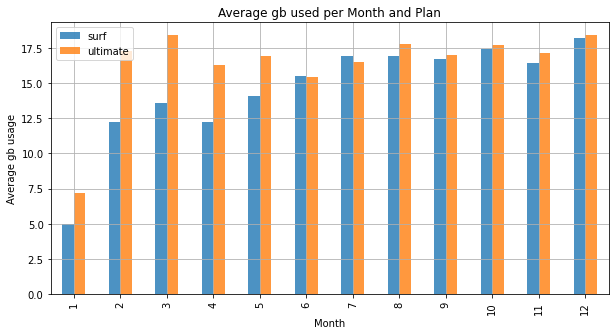

In [34]:
average_internet_used = merged_data_rate.groupby(['plan','month'])['gb_rounded'].mean().reset_index().round(1)

pivot_table_internet = average_internet_used.pivot(index='month' ,columns='plan' ,values='gb_rounded')
pivot_table_internet.columns = ['surf', 'ultimate']
pivot_table_internet.reset_index(inplace=True)

pivot_table_internet.plot(kind='bar', 
                           x= 'month',
                           figsize=(10, 5),
                           title='Average gb used per Month and Plan',
                           xlabel='Month',
                           ylabel='Average gb usage',  
                           alpha=0.8, 
                           grid=True)

plt.show()

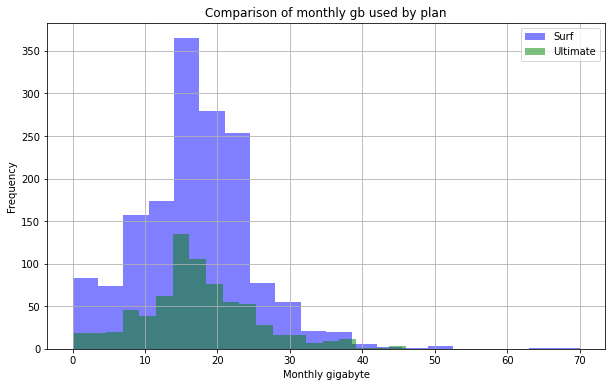

Media de gb usados (Surf): 16.7
Media de gb usados (Ultimate): 17.3
Varianza de los gb usados (Surf): 61.6
Varianza de los gb usados (Ultimate): 58.8
Mediana de gb usados (Surf): 17.0
Mediana dde gb usados (Ultimate): 17.0
Moda de gb usados (Surf): 18
Moda de gb usados (Ultimate): 17
La desviación estandar de gb usados (Surf): 7.8
La desviación estandar de gb usados (Ultimate): 7.7


In [35]:
surf_internet = merged_data_rate[merged_data_rate['plan'] == 'surf']['gb_rounded']
ultimate_internet = merged_data_rate[merged_data_rate['plan'] == 'ultimate']['gb_rounded']

plt.figure(figsize=(10, 6))
plt.hist(surf_internet, bins=20, alpha=0.5, label='Surf', color='blue')
plt.hist(ultimate_internet, bins=20, alpha=0.5, label='Ultimate', color='green')

plt.xlabel('Monthly gigabyte')
plt.ylabel('Frequency')
plt.title('Comparison of monthly gb used by plan')
plt.legend()
plt.grid(True)

plt.show()

surf_internet_m = merged_data_rate[merged_data_rate['plan'] == 'surf']['gb_rounded'].mean()
ultimate_internet_m = merged_data_rate[merged_data_rate['plan'] == 'ultimate']['gb_rounded'].mean()
surf_internet_variance = merged_data_rate[merged_data_rate['plan'] == 'surf']['gb_rounded'].var()
ultimate_internet_variance = merged_data_rate[merged_data_rate['plan'] == 'ultimate']['gb_rounded'].var()

surf_internet_median = merged_data_rate[merged_data_rate['plan'] == 'surf']['gb_rounded'].median()
ultimate_internet_median = merged_data_rate[merged_data_rate['plan'] == 'ultimate']['gb_rounded'].median()
surf_internet_mode = merged_data_rate[merged_data_rate['plan'] == 'surf']['gb_rounded'].mode()[0]
ultimate_internet_mode = merged_data_rate[merged_data_rate['plan'] == 'ultimate']['gb_rounded'].mode()[0]
surf_internet__std = merged_data_rate[merged_data_rate['plan'] == 'surf']['gb_rounded'].std()
ultimate_internet_std = merged_data_rate[merged_data_rate['plan'] == 'ultimate']['gb_rounded'].std()



print("Media de gb usados (Surf):", surf_internet_m.round(1))
print("Media de gb usados (Ultimate):", ultimate_internet_m.round(1))
print("Varianza de los gb usados (Surf):", surf_internet_variance.round(1))
print("Varianza de los gb usados (Ultimate):", ultimate_internet_variance.round(1))

print("Mediana de gb usados (Surf):", surf_internet_median.round(1))
print("Mediana dde gb usados (Ultimate):", ultimate_internet_median.round(1))
print("Moda de gb usados (Surf):", surf_internet_mode.round(1))
print("Moda de gb usados (Ultimate):", ultimate_internet_mode.round(1))
print("La desviación estandar de gb usados (Surf):", surf_internet__std.round(1))
print("La desviación estandar de gb usados (Ultimate):", ultimate_internet_std.round(1))

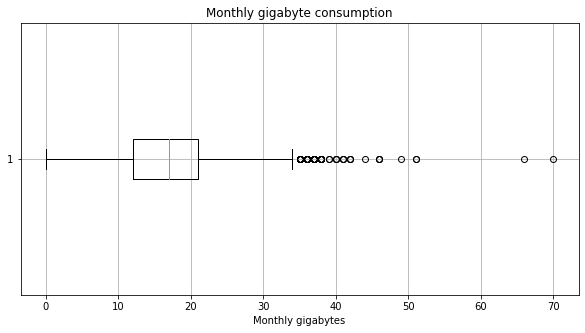

El valor del Q1 es de: 12.0
El valor del Q3 es de: 21.0
El valor máximo es de: 34.5
El valor máximo átipico es: 70


In [36]:
internet_data = merged_data_rate['gb_rounded']

plt.figure(figsize = (10,5))
plt.boxplot(internet_data, vert=False)

plt.xlabel('Monthly gigabytes')
plt.title('Monthly gigabyte consumption')
plt.grid(True)

plt.show()

q1_gb = np.percentile(internet_data, 25)
q3_gb = np.percentile(internet_data, 75)

print('El valor del Q1 es de:' ,q1_gb)
print('El valor del Q3 es de:' ,q3_gb)

max_value_gb = q3_gb + (1.5*(q3_gb-q1_gb))
print('El valor máximo es de:' , max_value_gb)

maximum_atypical_value_gb = np.max(internet_data)
print('El valor máximo átipico es:' ,maximum_atypical_value_gb)

[Elabora las conclusiones sobre cómo los usuarios tienden a consumir el tráfico de Internet. ¿Su comportamiento varía en función del plan?]

     Los usuarios de ambos planes tienden a utilizar una cantidad similar de gigabytes en promedio, sin que su plan parezca tener influencia en su comportamiento de consumo, pero hay algunos usuarios atípicos que utilizan una cantidad significativamente mayor de gigabytes en comparación con el resto de los usuarios.

## Ingreso

Del mismo modo que se ha estudiado el comportamiento de los usuarios, se describe estadísticamente los ingresos de los planes.

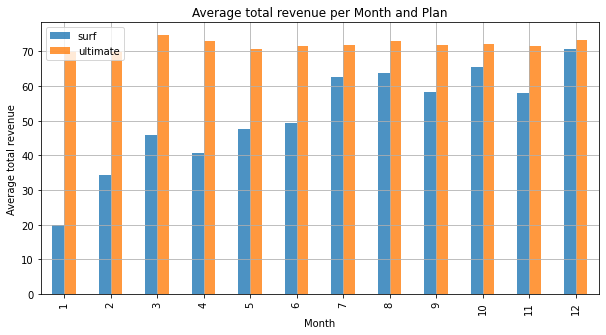

In [37]:
avg_total_revenue = merged_data_rate.groupby(['plan','month'])['total_revenue'].mean().reset_index().round(1)

pivot_table_revenue = avg_total_revenue.pivot(index='month' ,columns='plan' ,values='total_revenue')
pivot_table_revenue.columns = ['surf', 'ultimate']
pivot_table_revenue.reset_index(inplace=True)

pivot_table_revenue.plot(kind='bar', 
                         x= 'month',
                         figsize=(10, 5),
                         title='Average total revenue per Month and Plan',
                         xlabel='Month',
                         ylabel='Average total revenue',  
                         alpha=0.8, 
                         grid=True)

plt.show()

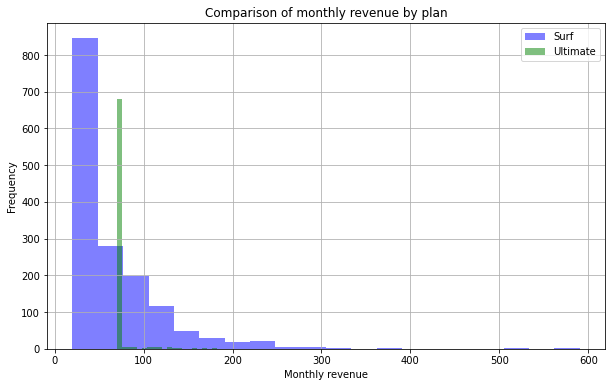

Media de ingresos (Surf): 60.7
Media de ingresos (Ultimate): 72.3
Varianza de los ingresos (Surf): 3067.8
Varianza de los ingresos (Ultimate): 129.8
Mediana de ingresos (Surf): 40.4
Mediana de ingresos (Ultimate): 70.0
Moda de ingresos (Surf): 0    20.0
dtype: float64
Moda de ingresos (Ultimate): 0    70.0
dtype: float64
La desviación estandar de ingresos (Surf): 55.4
La desviación estandar de ingresos (Ultimate): 11.4


In [38]:
surf_revenue = merged_data_rate[merged_data_rate['plan'] == 'surf']['total_revenue']
ultimate_revenue = merged_data_rate[merged_data_rate['plan'] == 'ultimate']['total_revenue']

plt.figure(figsize=(10, 6))
plt.hist(surf_revenue, bins=20, alpha=0.5, label='Surf', color='blue')
plt.hist(ultimate_revenue, bins=20, alpha=0.5, label='Ultimate', color='green')

plt.xlabel('Monthly revenue')
plt.ylabel('Frequency')
plt.title('Comparison of monthly revenue by plan')
plt.legend()
plt.grid(True)

plt.show()

surf_revenue_m = merged_data_rate[merged_data_rate['plan'] == 'surf']['total_revenue'].mean()
ultimate_revenue_m = merged_data_rate[merged_data_rate['plan'] == 'ultimate']['total_revenue'].mean()
surf_revenue_variance = merged_data_rate[merged_data_rate['plan'] == 'surf']['total_revenue'].var()
ultimate_revenue_variance = merged_data_rate[merged_data_rate['plan'] == 'ultimate']['total_revenue'].var()
surf_revenue_median = merged_data_rate[merged_data_rate['plan'] == 'surf']['total_revenue'].median()
ultimate_revenue_median = merged_data_rate[merged_data_rate['plan'] == 'ultimate']['total_revenue'].median()
surf_revenue_mode = merged_data_rate[merged_data_rate['plan'] == 'surf']['total_revenue'].mode()
ultimate_revenue_mode = merged_data_rate[merged_data_rate['plan'] == 'ultimate']['total_revenue'].mode()
surf_revenue_std = merged_data_rate[merged_data_rate['plan'] == 'surf']['total_revenue'].std()
ultimate_revenue_std = merged_data_rate[merged_data_rate['plan'] == 'ultimate']['total_revenue'].std()


print("Media de ingresos (Surf):", surf_revenue_m.round(1))
print("Media de ingresos (Ultimate):", ultimate_revenue_m.round(1))
print("Varianza de los ingresos (Surf):", surf_revenue_variance.round(1))
print("Varianza de los ingresos (Ultimate):", ultimate_revenue_variance.round(1))
print("Mediana de ingresos (Surf):", surf_revenue_median.round(1))
print("Mediana de ingresos (Ultimate):", ultimate_revenue_median.round(1))
print("Moda de ingresos (Surf):", surf_revenue_mode.round(1))
print("Moda de ingresos (Ultimate):", ultimate_revenue_mode.round(1))
print("La desviación estandar de ingresos (Surf):", surf_revenue_std.round(1))
print("La desviación estandar de ingresos (Ultimate):", ultimate_revenue_std.round(1))

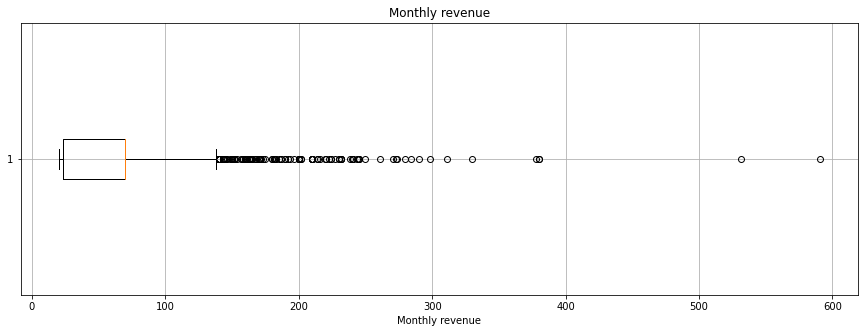

El valor del Q1 es de: 23.48
El Valor de Q2 es de: 70.0
El valor del Q3 es de: 70.0
El valor máximo es de: 139.78
El valor máximo atípico es: 590.37


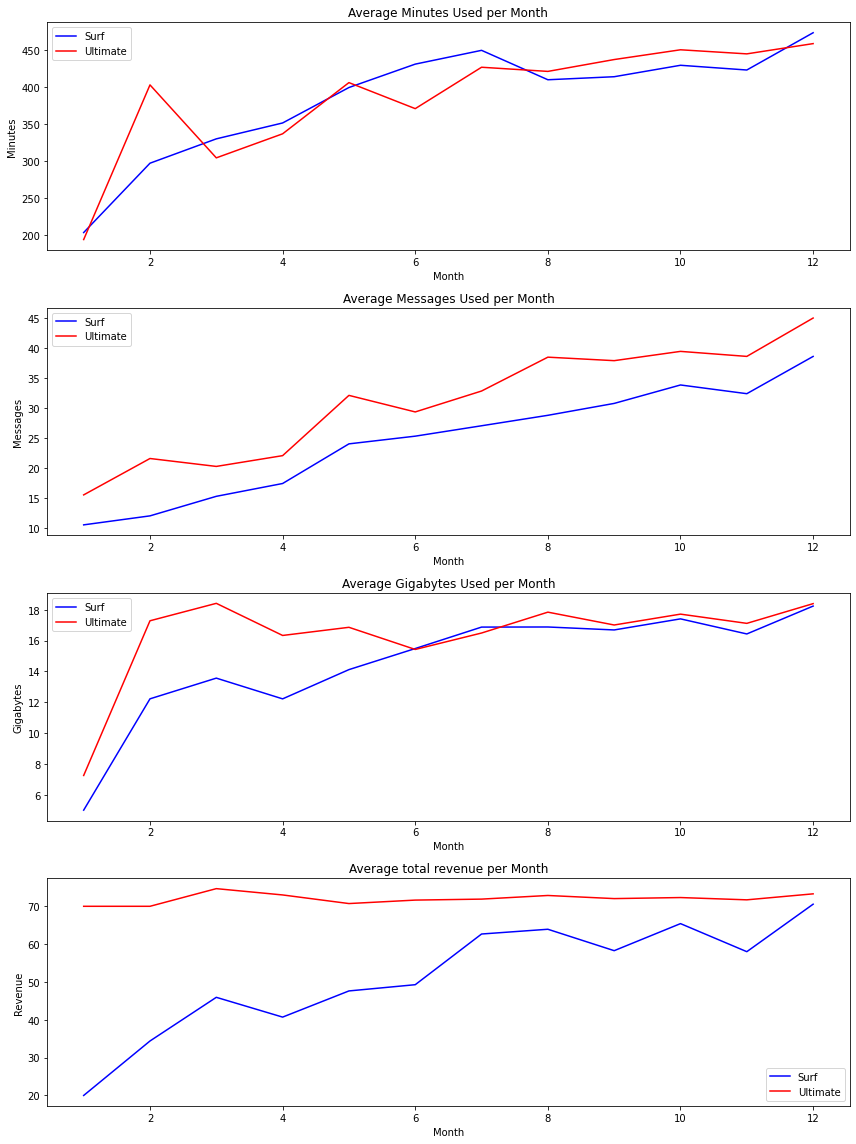

In [39]:
revenue_data = merged_data_rate['total_revenue']

plt.figure(figsize = (15,5))
plt.boxplot(revenue_data, vert=False)

plt.xlabel('Monthly revenue')
plt.title('Monthly revenue')
plt.grid(True)

plt.show()

q1_rv = np.percentile(revenue_data, 25)
q3_rv = np.percentile(revenue_data, 75)

print('El valor del Q1 es de:' ,q1_rv)
print('El Valor de Q2 es de:' , np.percentile(revenue_data, 50))
print('El valor del Q3 es de:' ,q3_rv)

max_value_rv = q3_rv + (1.5*(q3_rv-q1_rv))
print('El valor máximo es de:' , max_value_rv)

maximum_atypical_value_rv = np.max(revenue_data)
print('El valor máximo atípico es:' ,maximum_atypical_value_rv)

surf_info = merged_data_rate[merged_data_rate['plan'] == 'surf']
ultimate_info = merged_data_rate[merged_data_rate['plan'] == 'ultimate']

surf_means = surf_info.groupby('month').mean()
ultimate_means = ultimate_info.groupby('month').mean()

fig, axs = plt.subplots(4, 1, figsize=(12, 16))

axs[0].plot(surf_means.index, surf_means['minutes_used'], label='Surf', color='blue')
axs[0].plot(ultimate_means.index, ultimate_means['minutes_used'], label='Ultimate', color='red')
axs[0].set_title('Average Minutes Used per Month')
axs[0].set_xlabel('Month')
axs[0].set_ylabel('Minutes')
axs[0].legend()

axs[1].plot(surf_means.index, surf_means['message_count'], label='Surf', color='blue')
axs[1].plot(ultimate_means.index, ultimate_means['message_count'], label='Ultimate', color='red')
axs[1].set_title('Average Messages Used per Month')
axs[1].set_xlabel('Month')
axs[1].set_ylabel('Messages')
axs[1].legend()

axs[2].plot(surf_means.index, surf_means['gb_rounded'], label='Surf', color='blue')
axs[2].plot(ultimate_means.index, ultimate_means['gb_rounded'], label='Ultimate', color='red')
axs[2].set_title('Average Gigabytes Used per Month')
axs[2].set_xlabel('Month')
axs[2].set_ylabel('Gigabytes')
axs[2].legend()

axs[3].plot(surf_means.index, surf_means['total_revenue'], label='Surf', color='blue')
axs[3].plot(ultimate_means.index, ultimate_means['total_revenue'], label='Ultimate', color='red')
axs[3].set_title('Average total revenue per Month')
axs[3].set_xlabel('Month')
axs[3].set_ylabel('Revenue')
axs[3].legend()


plt.tight_layout()
plt.show()

    La variabilidad en el gasto mensual es mayor en el plan "Surf" en comparación con el plan "Ultimate". Mientras que la mayoría de los usuarios de "Ultimate" se adhieren a su tarifa base, algunos usuarios de "Surf" tienden a gastar más a medida que avanza el tiempo. Esto podría indicar que el plan "Surf" atrae a usuarios con diferentes patrones de gasto y una mayor variabilidad en sus consumos mensuales.

## Prueba las hipótesis estadísticas

Hipótesis nula: No hay diferencia entre los ingresos promedio de los usuarios de los planes 'Ultimate' y 'Surf'.

Hipótesis alternativa: Existe una diferencia significativa entre los ingresos promedio de los usuarios de los planes 'Ultimate' y 'Surf'.

In [40]:
surf_income = merged_data_rate[merged_data_rate['plan'] == 'surf']['total_revenue']
ultimate_income = merged_data_rate[merged_data_rate['plan'] == 'ultimate']['total_revenue']

levene_test = st.levene(surf_income, ultimate_income)

alpha = 0.05

if (levene_test.pvalue < alpha):
    print("Rechazamos la hipótesis nula: Las varianzas son diferentes.")
else:
    print("No podemos rechazar la hipótesis nula: Las varianzas son iguales.")

results = st.ttest_ind(surf_income, ultimate_income, equal_var=False)

if (results.pvalue < alpha):
    print("Se acepta la hipótesis nula: No hay evidencia suficiente para concluir que existe una diferencia significativa entre los ingresos promedio de los usuarios de los planes 'Ultimate' y 'Surf'.")
else:
    print("Se rechaza la hipótesis nula: Existe evidencia suficiente para concluir que hay una diferencia significativa entre los ingresos promedio de los usuarios de los planes 'Ultimate' y 'Surf'.")

Rechazamos la hipótesis nula: Las varianzas son diferentes.
Se acepta la hipótesis nula: No hay evidencia suficiente para concluir que existe una diferencia significativa entre los ingresos promedio de los usuarios de los planes 'Ultimate' y 'Surf'.


.

Hipótesis nula: No hay una diferencia significativa en el ingreso promedio entre el área NY-NJ y otras regiones.

Hipótesis alternativa: Existe una diferencia significativa en el ingreso promedio entre el área NY-NJ y otras regiones.

In [41]:
ny_nj_income = merged_data_rate[merged_data_rate['city'] == 'New York-Newark-Jersey City, NY-NJ-PA MSA']['total_revenue']
other_region_income = merged_data_rate[merged_data_rate['city'] != 'New York-Newark-Jersey City, NY-NJ-PA MSA']['total_revenue']

alfa = 0.05

levene_test_zone = st.levene(ny_nj_income, other_region_income)

if (levene_test_zone.pvalue < alpha):
    print("Rechazamos la hipótesis nula: Las varianzas son diferentes.")
else:
    print("No podemos rechazar la hipótesis nula: Las varianzas son iguales.")

results_2 = st.ttest_ind(ny_nj_income, other_region_income, equal_var=True)


if (results_2.pvalue < alfa):
    print("Hay evidencia para rechazar la hipótesis nula: no hay una diferencia significativa en el ingreso promedio entre el área NY-NJ y otras regiones.")
else:
    print("No hay suficiente evidencia para rechazar la hipótesis nula: hay una diferencia significativa en el ingreso promedio entre el área NY-NJ y otras regiones.")

No podemos rechazar la hipótesis nula: Las varianzas son iguales.
Hay evidencia para rechazar la hipótesis nula: no hay una diferencia significativa en el ingreso promedio entre el área NY-NJ y otras regiones.


## Conclusión general

    *Carga de datos*
    Para comenzar con el ánalisis, se reciben 5 archivos con 5 tablas diferentes, teniendo en común entre estos archivos, algunas columnas. 
    Se cargaron las librerías con las que estaría trabajando y se cargaron los archivos.
    
    
    *Modificación de datos*
    Se comienza a verificar con qué tipos de datos contaban cada una de las tablas, con el objetivo de conocer sus características, tipos de datos y existencia o ausencia de datos nulos. 
    Para poder trabajar fluidamente con los datos, se hicieron las adaptaciones necesarias para su posterior uso, como fue redondear hacia arriba los minutos de llamadas, convertir datos de mb a gb, así como modificar el tipo de dato de algunas columnas a datetime, para su correcto uso y su correcta utilidad. También se modificaron o se agregaron columnas con información extraída de las mismas tablas, con el objetivo de ser utilizadas en un futuro. Por ejemplo, se crearon columnas donde se indicaba únicamente el mes, para poder trabajar con ello, cree una tabla donde se pudiera ver el consumo mensual de cada uno de los servicios, indicando que plan y que tarifas pagarían los clientes por exceder su límite incluido de consumo.
    
    *Trabajo con datos*
    Se comenzó a conocer el comportamiento del usuario, tanto en su duración de llamadas, uso de mensajes de texto, consumo de GB de internet y de su facturación mensual. Para ello, se buscó conocer y ver el promedio de consumo de los clientes dependiendo de su plan por los meses a lo largo del año. Se utilizó un gráfico de barras para poder visualizar esto. 
    Posteriormente, para observar la frecuencia del uso de los diferentes servicios por parte de los clientes, dependiendo de su plan, utilizamos un histograma que nos permitirá ver el comportamiento de consumo de los servicios. 
    Se utilizó un gráfico boxplot para poder observar la dispersión de los valores, donde además de poder observar dónde se encontraba ubicado el 50% de nuestros datos, también nos permitía observar más claramente la ubicación y representación de los valores atípicos
    
    *Generación y comprobación de hipótesis* 
    Para terminar, se generaron hipótesis con base a los requerimientos solicitados por Megaline y se hicieron las pruebas pertinentes para determinar si esas hipótesis se aceptaban o se rechazaba. De este ultimo paso podemos indicar lo siguiente:
    Podemos concluir que para Megaline, ambos planes generan una cantidad de ingresos similar, por lo que si requieren realizar algún ajuste de publicidad, no será determinado en este caso, por alguna discrepancia en la generación de ingresos acorde al plan. 
    Hemos rechazado la hipotesis nula sobre que no hay una diferencia significativa en el ingreso promedio entre el área NY-NJ y otras regiones, pero podríamos sugerir considerar estudiar otras regiones o ajustar más el umbral nivel de significación si se busca ser más estricto en el estudio, si es que se buscar realizar alguna acción especifica por regiones acorde a los datos arrojados por el estudio.
